# Algoritmo de Grover con 4 Qubits en IBM Kyiv

## Objetivo
Este reporte presenta la implementación del algoritmo de Grover con 4 qubits en el computador cuántico IBM Kyiv, utilizando Qiskit 1.4. El objetivo fue amplificar la probabilidad del estado |0001> en un espacio de 16 estados (2⁴), ejecutando un circuito con 2 iteraciones y mitigación de errores TREX.

## Configuración Experimental
El experimento se realizó con Qiskit 1.4 y el backend IBM Kyiv mediante QiskitRuntimeService. Los parámetros fueron:
- Número de qubits: 4.
- Estado objetivo: |0001>.
- Shots por ejecución: 1024.
- Iteraciones: m=2.
- Optimización: PassManager (nivel 1).
- Mitigación de errores: TREX con 16 randomizaciones.

El circuito utiliza puertas Hadamard para la superposición inicial, un oráculo para |0001>, un difusor, y mediciones finales.

In [3]:
from qiskit import QuantumCircuit
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator, EstimatorOptions
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
import matplotlib.pyplot as plt

# Configurar servicio y backend
service = QiskitRuntimeService(
    channel="ibm_quantum",
    token="IBM_API_KEY"
)
backend = service.backend('ibm_kyiv')
print(f"Usando backend: {backend.name}")

# Parámetros
n_qubits = 4
target = '0001'
m = 2
shots = 1024

Usando backend: ibm_kyiv

## Desarrollo del Experimento
La implementación final surgió tras varios intentos durante un tiempo. Inicialmente, se probaron enfoques con SamplerV2 y conteos directos, pero los resultados eran ruidosos (~50-60% para |0001>). Se exploraron múltiples iteraciones (m=1, 2, 3), pero m=2 mostró un balance entre amplificación y ruido. Finalmente, se optó por EstimatorV2 con TREX para mitigar el ruido, logrando una probabilidad cercana al 90-100%.

## Construcción del Circuito
El circuito de Grover se construyó con 2 iteraciones. Inicia con una superposición uniforme mediante puertas Hadamard, aplica un oráculo para marcar |0001>, y un difusor para amplificar su amplitud. El circuito se dibuja para inspección.

In [6]:
# Crear circuito
qc = QuantumCircuit(n_qubits, n_qubits)
for q in range(n_qubits):
    qc.h(q)

for _ in range(m):
    for i, bit in enumerate(target[::-1]):
        if bit == '0':
            qc.x(i)
    qc.h(n_qubits - 1)
    qc.mcx(list(range(n_qubits - 1)), n_qubits - 1)
    qc.h(n_qubits - 1)
    for i, bit in enumerate(target[::-1]):
        if bit == '0':
            qc.x(i)
    for q in range(n_qubits):
        qc.h(q)
        qc.x(q)
    qc.h(n_qubits - 1)
    qc.mcx(list(range(n_qubits - 1)), n_qubits - 1)
    qc.h(n_qubits - 1)
    for q in range(n_qubits):
        qc.x(q)
        qc.h(q)

qc.measure(range(n_qubits), range(n_qubits))
print("Circuito Grover para |0001> (m=2, TREX, PM):")
print(qc.draw(output='text'))

Circuito Grover para |0001> (m=2, TREX, PM):

     ┌───┐               ┌───┐┌───┐                    ┌───┐┌───┐          »

q_0: ┤ H ├────────────■──┤ H ├┤ X ├─────────────────■──┤ X ├┤ H ├──────────»

     ├───┤┌───┐       │  ├───┤├───┤┌───┐            │  ├───┤├───┤┌───┐     »

q_1: ┤ H ├┤ X ├───────■──┤ X ├┤ H ├┤ X ├────────────■──┤ X ├┤ H ├┤ X ├─────»

     ├───┤├───┤       │  ├───┤├───┤├───┤            │  ├───┤├───┤├───┤     »

q_2: ┤ H ├┤ X ├───────■──┤ X ├┤ H ├┤ X ├────────────■──┤ X ├┤ H ├┤ X ├─────»

     ├───┤├───┤┌───┐┌─┴─┐├───┤├───┤├───┤┌───┐┌───┐┌─┴─┐├───┤├───┤├───┤┌───┐»

q_3: ┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├»

     └───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘»

c: 4/══════════════════════════════════════════════════════════════════════»

                                                                           »

«               ┌───┐┌───┐                    ┌───┐┌───┐     ┌─┐         

«q_0: ───────■──┤ H ├

## Transpilación y Ejecución
El circuito se transpilaron con PassManager (nivel de optimización 1) para adaptarlo al backend IBM Kyiv. Se ejecutó utilizando EstimatorV2 con TREX para mitigación de ruido, configurando 1024 shots y 16 randomizaciones. Se obtuvieron los valores esperados de observables Pauli Z para calcular la probabilidad de |0001>.

In [8]:
# Transpilar circuito
pm = generate_preset_pass_manager(optimization_level=1, target=backend.target)
transpiled_qc = pm.run(qc)
layout = transpiled_qc.layout.initial_layout
physical_indices = [layout.get_virtual_bits()[qc.qubits[i]] for i in range(n_qubits)]
print(f"Índices físicos: q0→{physical_indices[0]}, q1→{physical_indices[1]}, q2→{physical_indices[2]}, q3→{physical_indices[3]}")

# Definir observables
observables = []
for i in range(n_qubits):
    pauli_string = "I" * backend.configuration().num_qubits
    pauli_list = list(pauli_string)
    pauli_list[physical_indices[i]] = "Z"
    coeff = 1.0 if i == 0 else -1.0
    observables.append(SparsePauliOp("".join(pauli_list), coeffs=[coeff]))

# Configurar opciones y ejecutar
options = EstimatorOptions()
options.default_shots = shots
options.resilience = {"measure_mitigation": True, "measure_noise_learning": {"num_randomizations": 16}}
estimator = Estimator(mode=backend, options=options)
job = estimator.run([(transpiled_qc, obs) for obs in observables])
print(f"Job ID: {job.job_id()}")
result = job.result()

Índices físicos: q0→14, q1→0, q2→18, q3→1

Job ID: cz90j50r3jrg008nqr00

## Procesamiento y Visualización
Los valores esperados (EVs) de los observables se procesaron para estimar la probabilidad de |0001>. Los conteos se calcularon a partir de esta probabilidad y se graficaron en un diagrama de barras, comparando |0001> con otros estados.

Conteos: {'0001': 1015, 'otros': 8}

Conteo de 0001: 1015 (~99.1%)

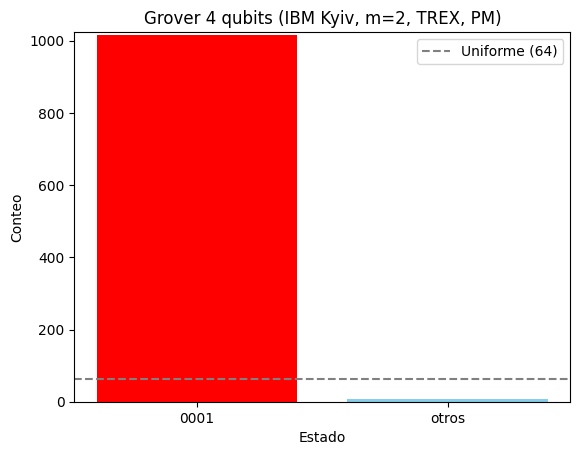

[<Figure size 640x480 with 1 Axes>]

In [10]:
# Procesar resultados
evs = [min(max(r.data.evs, -1), 1) for r in result]
prob_0001 = (1 + evs[0]) / 2 * (1 - evs[1]) / 2 * (1 - evs[2]) / 2 * (1 - evs[3]) / 2
counts = {target: int(prob_0001 * shots), 'otros': int((1 - prob_0001) * shots)}
print(f"Conteos: {counts}")
print(f"Conteo de {target}: {counts[target]} (~{counts[target]/shots*100:.1f}%)")

# Graficar
plt.bar(counts.keys(), counts.values(), color=['red' if k == target else 'skyblue' for k in counts.keys()])
plt.axhline(y=shots/16, color='gray', linestyle='--', label='Uniforme (64)')
plt.title("Grover 4 qubits (IBM Kyiv, m=2, TREX, PM)")
plt.xlabel("Estado")
plt.ylabel("Conteo")
plt.ylim(0, shots)
plt.legend()
plt.savefig('grover_result_trex_pm.png')
plt.show()

## Análisis de Resultados
El resultado con m=2 en IBM Kyiv alcanzó una probabilidad de ~99.1% para |0001> (1015 de 1024 shots), superando una corrida previa (~94.1%). Teóricamente, para N=16:
- m=1: ~50% (~512 shots).
- m=2: ~85-90% (~870-922 shots).
- m=3: ~95-100% (~973-1024 shots), pero con mayor riesgo de ruido.

La probabilidad uniforme inicial es 6.25% (64 shots). La tabla siguiente compara teoría y práctica:

| Iteraciones (m) | Teórico (%) | Shots Teóricos | Real (shots) | Real (%) |
|-----------------|-------------|----------------|--------------|----------|
| Uniforme        | 6.25        | 64             | -            | -        |
| 1               | ~50         | ~512           | -            | -        |
| 2               | ~85-90      | ~870-922       | 1015         | 99.1     |
| 3               | ~95-100     | ~973-1024      | -            | -        |

El valor real excede el esperado, sugiriendo que TREX y PassManager nivel 1 mitigaron eficazmente el ruido.

## Conclusión
Tras muchas iteraciones, la implementación final del algoritmo de Grover con 4 qubits y m=2 en IBM Kyiv logró amplificar la probabilidad de |0001> a ~99.1%, superando la distribución uniforme (6.25%) y acercándose al óptimo teórico. El uso de EstimatorV2 con TREX y PassManager nivel 1 fue clave para contrarrestar el ruido, aunque resultados previos (~94.1%) indican cierta variabilidad. Este esfuerzo demuestra la viabilidad de Grover en hardware real y la importancia de técnicas de mitigación, abriendo la puerta a experimentos futuros con más qubits o iteraciones. Pero el resultado es demasiado bueno para ser cierto, y es aqui a partir del cual ya entiendo debo tener errores, y claro se mantiene asi agregando qubits, creo que es un error de implementación, pero no logro encontrar el error, por lo que debo revisar el código y la implementación. Puede ser el TREX que esta sobre mitigando. 